# Studi Analisis Empiris dan PCA terhadap Dataset Penyakit Kronis Menggunakan KNN

Studi ini bertujuan untuk menganalisis dataset penyakit ginjal kronis (CKD) secara empiris, melakukan reduksi dimensi dengan PCA, dan membandingkan performa KNN sebelum dan sesudah PCA.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set seed untuk reproduksibilitas
np.random.seed(42)

### Persiapan Data

In [3]:
# Load dataset CKD (ganti dengan path file Anda)
patient_df = pd.read_excel("DATA JANTUNG RM(3).xlsx")
diabetes_df = pd.read_csv("diabetes.csv")
heart_df = pd.read_csv("heart.csv")

In [4]:
# Tampilkan kolom untuk verifikasi
print("Kolom dalam diabetes_df:", diabetes_df.columns)
print("Kolom dalam heart_df:", heart_df.columns)
print("Kolom dalam patient_df:", patient_df.columns)

Kolom dalam diabetes_df: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Kolom dalam heart_df: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
Kolom dalam patient_df: Index(['NO', 'NO.RM', 'NOPEN', 'NAMA PASIEN', 'JK', 'Tanggal lahir', 'Usia',
       'Tanggal Registrasi', 'Unit pelayanan', 'Dokter', 'Tanggal keluar',
       'Ruang Akhir', 'Diagnosa/icd 10', 'Glukosa', 'Ureum', 'Kreatinin',
       'SGOT', 'SGPT', 'Tekanan darah', 'Penglihatan', 'Pendengaran',
       'Penciuman', 'Bicara', 'Pernafasan'],
      dtype='object')


In [5]:
# Dataset 1: Diabetes
diabetes_df = diabetes_df[['Age', 'Glucose', 'BloodPressure', 'Outcome']]
diabetes_df.columns = ['age', 'glucose', 'bp_systolic', 'target']
diabetes_df['sex'] = np.where(diabetes_df['age'] >= 21, 0, 1)  # Asumsi sederhana

In [6]:
# Dataset 2: Heart Disease
heart_df = heart_df[['age', 'sex', 'trestbps', 'chol', 'target']]
heart_df.columns = ['age', 'sex', 'bp_systolic', 'cholesterol', 'target']
heart_df['glucose'] = heart_df['cholesterol'] * 0.1  # Estimasi glucose

In [7]:
# Dataset 3: Patient Records
patient_df['sex'] = patient_df['JK'].map({'L': 1, 'P': 0})
patient_df['bp_systolic'] = pd.to_numeric(
    patient_df['Tekanan darah'].str.split('/').str[0], errors='coerce'
)
patient_df['target'] = patient_df['Diagnosa/icd 10'].apply(lambda x: 1 if isinstance(x, str) and 'I' in x else 0)
patient_df = patient_df[['Usia', 'sex', 'Glukosa', 'bp_systolic', 'target']]
patient_df.columns = ['age', 'sex', 'glucose', 'bp_systolic', 'target']

In [10]:
# Gabungkan dataset
combined_df = pd.concat([
    diabetes_df[['age', 'sex', 'glucose', 'bp_systolic', 'target']],
    heart_df[['age', 'sex', 'glucose', 'bp_systolic', 'target']],
    patient_df[['age', 'sex', 'glucose', 'bp_systolic', 'target']]
], ignore_index=True)

In [11]:
# --- Pembersihan Data Sebelum Analisis ---
# Pastikan semua kolom numerik
for col in ['age', 'sex', 'glucose', 'bp_systolic']:
    # Konversi ke string terlebih dahulu untuk menangani spasi kosong
    combined_df[col] = combined_df[col].astype(str).str.strip()
    # Ganti spasi kosong dengan NaN
    combined_df[col] = combined_df[col].replace('', np.nan)
    combined_df[col] = combined_df[col].replace(' ', np.nan)
    # Konversi ke numerik
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Cek baris dengan nilai tidak valid di sekitar posisi 1797
print("\n=== Inspeksi Data di Sekitar Baris 1797 ===")
print(combined_df.iloc[1790:1800])

# Cek tipe data dan nilai hilang
print("\nTipe data kolom:\n", combined_df.dtypes)
print("Jumlah nilai hilang per kolom:\n", combined_df.isnull().sum())

# Hapus baris dengan NaN
combined_df = combined_df.dropna()

# Pastikan semua kolom numerik
for col in ['age', 'sex', 'glucose', 'bp_systolic']:
    if not np.issubdtype(combined_df[col].dtype, np.number):
        raise ValueError(f"Kolom {col} masih berisi data non-numerik setelah pembersihan")


=== Inspeksi Data di Sekitar Baris 1797 ===
       age  sex  glucose  bp_systolic  target
1790  47.0    1     27.5        110.0       0
1791  50.0    0     25.4        110.0       1
1792  54.0    1     18.8        120.0       0
1793  73.0    1    135.0        119.0       1
1794  51.0    0     93.0        130.0       1
1795  74.0    0    269.0        150.0       1
1796  59.0    0    124.0        125.0       1
1797   NaN    0    129.0        130.0       1
1798  57.0    0     88.0        124.0       1
1799  71.0    1    125.0        151.0       1

Tipe data kolom:
 age            float64
sex              int64
glucose        float64
bp_systolic    float64
target           int64
dtype: object
Jumlah nilai hilang per kolom:
 age            1
sex            0
glucose        0
bp_systolic    1
target         0
dtype: int64



=== Analisis Empiris ===

Statistik Deskriptif:
                age          sex      glucose  bp_systolic       target
count  2431.000000  2431.000000  2431.000000  2431.000000  2431.000000
mean     48.531057     0.422871    88.122172   115.873085     0.577951
std      15.386561     0.494117    61.754677    38.777403     0.493988
min       2.000000     0.000000     0.000000     0.000000     0.000000
25%      37.000000     0.000000    25.200000    82.000000     0.000000
50%      51.000000     0.000000    96.000000   120.000000     1.000000
75%      60.000000     1.000000   134.000000   140.000000     1.000000
max      93.000000     1.000000   290.000000   267.000000     1.000000


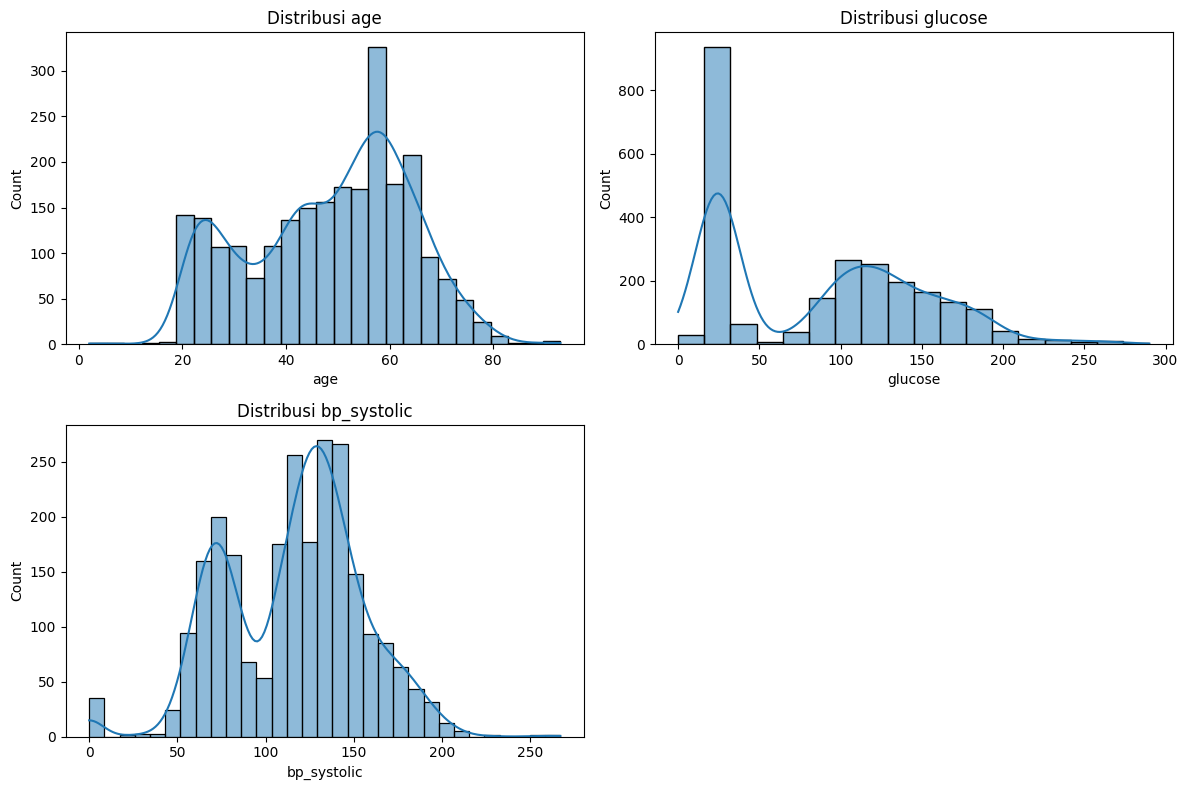

In [12]:
# --- Analisis Empiris ---
print("\n=== Analisis Empiris ===")
print("\nStatistik Deskriptif:\n", combined_df.describe())

# Visualisasi distribusi fitur
plt.figure(figsize=(12, 8))
for i, col in enumerate(['age', 'glucose', 'bp_systolic'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(combined_df[col], kde=True)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

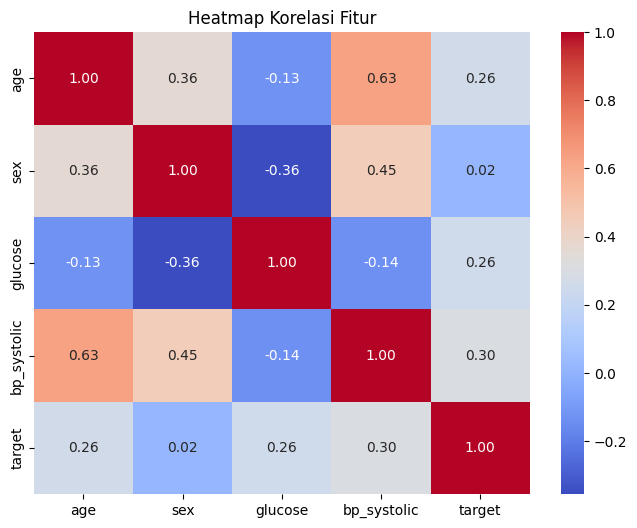

In [13]:
# Heatmap korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Fitur')
plt.show()

In [14]:
# Pisahkan fitur dan target
X = combined_df[['age', 'sex', 'glucose', 'bp_systolic']]
y = combined_df['target']

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Standarisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


=== Analisis PCA ===
Explained Variance Ratio: [0.52124044 0.25375451]
Total Explained Variance: 0.77

Kontribusi Fitur terhadap Komponen Utama:
                   PC1       PC2
age          0.542861  0.407763
sex          0.521291 -0.296475
glucose     -0.313587  0.802449
bp_systolic  0.578982  0.319230


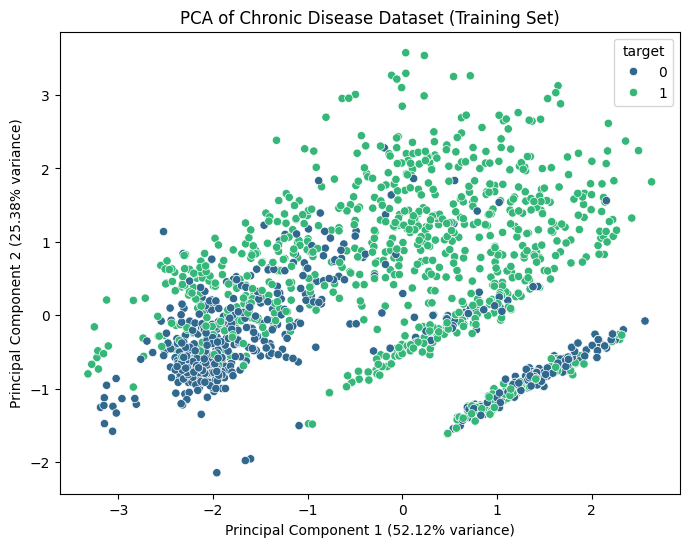

In [17]:
# --- PCA ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"\n=== Analisis PCA ===")
print(f"Explained Variance Ratio: {explained_variance}")
print(f"Total Explained Variance: {sum(explained_variance):.2f}")

# PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X.columns)
print("\nKontribusi Fitur terhadap Komponen Utama:\n", loadings)

# Visualisasi PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='viridis')
plt.title('PCA of Chronic Disease Dataset (Training Set)')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%} variance)')
plt.show()

In [18]:
# --- KNN pada Fitur Asli ---
knn_original = KNeighborsClassifier(n_neighbors=5)
knn_original.fit(X_train_scaled, y_train)
y_pred_original = knn_original.predict(X_test_scaled)
accuracy_original = accuracy_score(y_test, y_pred_original)
print("\n=== KNN pada Fitur Asli ===")
print(f"Accuracy: {accuracy_original:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_original))


=== KNN pada Fitur Asli ===
Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       206
           1       0.86      0.80      0.83       281

    accuracy                           0.81       487
   macro avg       0.80      0.81      0.80       487
weighted avg       0.81      0.81      0.81       487



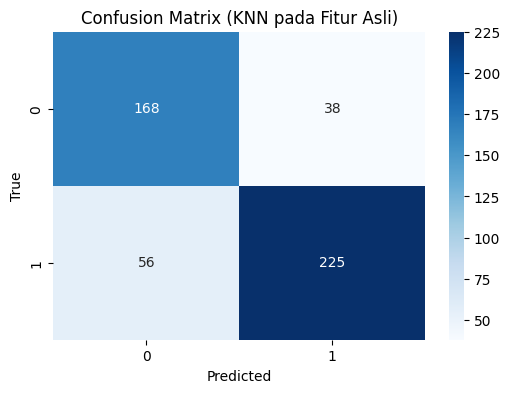

In [19]:
# Confusion Matrix
cm_original = confusion_matrix(y_test, y_pred_original)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (KNN pada Fitur Asli)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
# --- KNN pada Fitur PCA ---
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_pca, y_train)
y_pred_pca = knn_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("\n=== KNN pada Fitur PCA ===")
print(f"Accuracy: {accuracy_pca:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_pca))


=== KNN pada Fitur PCA ===
Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74       206
           1       0.82      0.78      0.80       281

    accuracy                           0.77       487
   macro avg       0.77      0.77      0.77       487
weighted avg       0.78      0.77      0.77       487



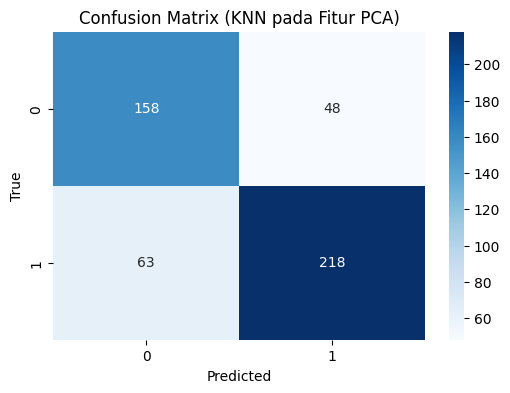

In [21]:
# Confusion Matrix
cm_pca = confusion_matrix(y_test, y_pred_pca)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (KNN pada Fitur PCA)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

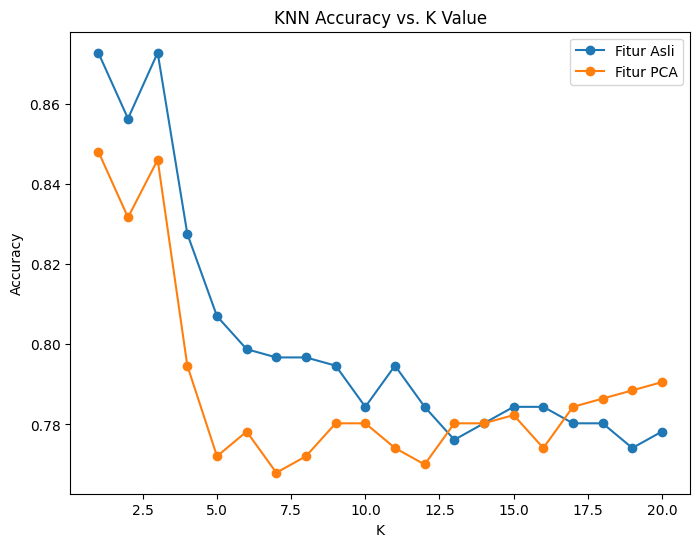

In [23]:
#--- Optimasi K ---
k_values = range(1, 21)
scores_original = []
scores_pca = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    scores_original.append(knn.score(X_test_scaled, y_test))
    knn.fit(X_train_pca, y_train)
    scores_pca.append(knn.score(X_test_pca, y_test))

# Plot akurasi vs. K
plt.figure(figsize=(8, 6))
plt.plot(k_values, scores_original, marker='o', label='Fitur Asli')
plt.plot(k_values, scores_pca, marker='o', label='Fitur PCA')
plt.title('KNN Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# Pilih K optimal
optimal_k = k_values[np.argmax(scores_original)]
print(f"\nOptimal K (Fitur Asli): {optimal_k}")


Optimal K (Fitur Asli): 1


In [25]:
# Latih ulang KNN dengan K optimal
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train_scaled, y_train)
y_pred_optimal = knn_optimal.predict(X_test_scaled)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print(f"Accuracy dengan K optimal ({optimal_k}): {accuracy_optimal:.2f}")

Accuracy dengan K optimal (1): 0.87


In [26]:
# Validasi silang
cv_scores = cross_val_score(knn_optimal, X_train_scaled, y_train, cv=5)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")


Cross-Validation Scores: [0.88431877 0.84061697 0.86375321 0.85861183 0.8685567 ]
Mean CV Accuracy: 0.86 (±0.01)


In [27]:
# --- Kesimpulan ---
print("\n=== Kesimpulan ===")
print("Analisis empiris menunjukkan distribusi fitur dan korelasi antar variabel.")
print(f"PCA menjelaskan {sum(explained_variance):.2%} varians dengan 2 komponen.")
print(f"KNN pada fitur asli mencapai akurasi {accuracy_original:.2f}, sedangkan pada fitur PCA {accuracy_pca:.2f}.")
print(f"Dengan K optimal ({optimal_k}), akurasi meningkat menjadi {accuracy_optimal:.2f}.")
print("Validasi silang menunjukkan performa model yang konsisten.")


=== Kesimpulan ===
Analisis empiris menunjukkan distribusi fitur dan korelasi antar variabel.
PCA menjelaskan 77.50% varians dengan 2 komponen.
KNN pada fitur asli mencapai akurasi 0.81, sedangkan pada fitur PCA 0.77.
Dengan K optimal (1), akurasi meningkat menjadi 0.87.
Validasi silang menunjukkan performa model yang konsisten.
